<a href="https://colab.research.google.com/github/Nahom32/GBLO/blob/main/notebooks/Gradient_Based_Learning_Variants.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
import matplotlib.pyplot as plt


In [37]:
(raw_train, raw_validation, raw_test),metadata= tfds.load(
    'malaria',
    split=['train[:80%]', 'train[80%:90%]','train[90%:]' ],  # The malaria dataset typically only has a 'train' split
    as_supervised=True,
    with_info=True,

)


In [38]:
def preprocess(image, label):
    image = tf.image.resize(image, (224, 224))  # image is a 3D tensor (H, W, C)
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
    return image, label


In [39]:
train_ds = raw_train.map(preprocess).shuffle(buffer_size=1000).batch(32).prefetch(tf.data.AUTOTUNE)
validation_ds = raw_validation.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = raw_test.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)


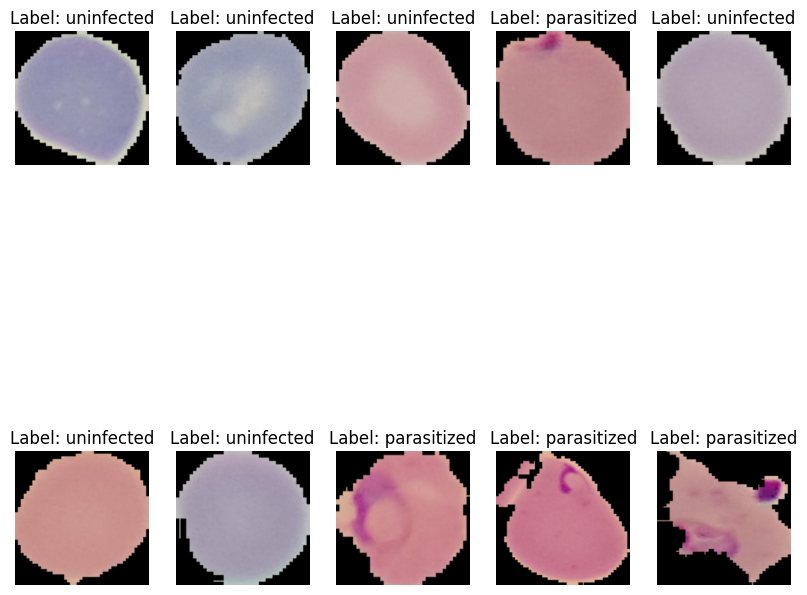

In [40]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(min(10, images.shape[0])):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].numpy())

        # Get the label name from metadata
        label_name = metadata.features['label'].names[labels[i].numpy()]
        plt.title(f"Label: {label_name}")
        plt.axis("off")
    plt.show()

In [41]:
from collections import Counter
class_names = metadata.features['label'].names
label_counts = Counter()
for _, labels in train_ds:
    label_counts.update(labels.numpy())
for label, count in label_counts.items():
    print(f"Class {class_names[label]}: {count} samples")

Class uninfected: 11047 samples
Class parasitized: 10999 samples


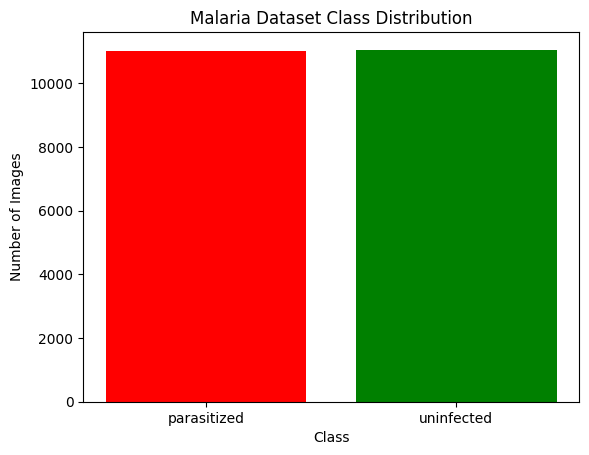

In [42]:
plt.bar(class_names, [label_counts[i] for i in range(len(class_names))], color=["red", "green"])
plt.title("Malaria Dataset Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()

In [43]:
model = Sequential([
    Flatten(input_shape=(224, 224, 3)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(2, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [44]:
from typing import Tuple
def train(model: tf.keras.Model, optimizer, train_ds: tf.data.Dataset, validation_ds: tf.data.Dataset) -> Tuple[tf.keras.Model, tf]:
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(train_ds, epochs=10, validation_data=validation_ds)
    return model, history

In [45]:
from sklearn.metrics import f1_score,accuracy_score
def score_model(model,test_ds):
  target_true = []
  target_predicted = []
  for x, y in test_ds:
    predicted = model.predict(x,verbose=0)
    target_true.extend(y.numpy())
    target_predicted.extend(tf.argmax(predicted, axis=1).numpy())
  f1 = f1_score(target_true, target_predicted, average='macro')
  accuracy = accuracy_score(target_true, target_predicted)
  return f1,accuracy

